# XGBoost model

A predictor model that will be used to predict mortality rate.
The target feature `hospital_death` are stored in `y_train` for training, `y_val` for validation and `y_test` for evaluation.
The features that are allowed as input are stored in `X_train`, `X_val` and `X_test`.

The dataset is large, and we will need to experiment to find out what hyperparamters are usefull.

## Training

In [64]:
# imports

import xgboost as xgb

import pandas as pd
from pandas import DataFrame
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import os
import sys
import asyncio

from tqdm import tqdm

print("Python version: \t", sys.version)
print("Pandas version: \t", pd.__version__)
print("NumPy version: \t\t", np.__version__)
print("Seaborn version: \t", sns.__version__)
print("XGBoost version: \t", xgb.__version__)

Python version: 	 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]
Pandas version: 	 2.2.3
NumPy version: 		 2.2.4
Seaborn version: 	 0.13.2
XGBoost version: 	 3.0.0


### Loading data

Data is preprocessed to not contain NaN's by a previous notebook, and is split into the correct datasets stored in the `./split data/` path.

In [26]:
# load the data

X_train = pd.read_csv(r"split data/X_train.csv")
y_train = pd.read_csv(r"split data/y_train.csv")

print(f"X_train - Rows: {X_train.shape[0]}, Columns: {X_train.shape[1]}, Number of NaNs: {X_train.isna().sum().sum()}")
print(f"y_train - Rows: {y_train.shape[0]}, Columns: {y_train.shape[1]}, Number of NaNs: {y_train.isna().sum().sum()}")

X_train - Rows: 64199, Columns: 174, Number of NaNs: 0
y_train - Rows: 64199, Columns: 1, Number of NaNs: 0


### Training variations

We wan't to experiment with different permutations of the hyperparameters. For this we setup a range of values to try, and try a set of realistic combinations.  
A model is trained for each combination and stored to disk.

In [72]:
hyperparam_configs = { # stores the ranges of hyperparameters to be tuned as a min, max and common step count (ranges are interpolated based on the step count to generate hyperparameter values)
    "step_count": 5, # number of hyperparameter values to be generated for each hyperparameter, at least 2! WARNING: The nr of models to train is step_count^2 !!! 5 steps is already 125 models to train!
    "n_estimators": {
        "type": int,
        "min": 50,
        "max": 2000, # OOF That's a lot
    },
    "max_depth": {
        "type": int,
        "min": 3,
        "max": 20,
    },
    "learning_rate": {
        "type": float,
        "min": 0.3,
        "max": 0.03,
    }
}

# Generate linearly interpolated values for each hyperparameter
hyperparameters = {
    param: [config["type"](val) for val in np.linspace(config["min"], config["max"], hyperparam_configs["step_count"])]
    for param, config in hyperparam_configs.items() if param != "step_count"
}

# Generate all permutations of the hyperparameters
hyperparameters_permutations = {
    param: [] for param in hyperparameters.keys()
}

# Use itertools.product to generate all combinations
all_combinations = list(product(*[hyperparameters[param] for param in hyperparameters.keys()]))

# Populate the dictionary with permutations
for combination in all_combinations:
    for i, param in enumerate(hyperparameters.keys()):
        hyperparameters_permutations[param].append(combination[i])

hyperparameters = hyperparameters_permutations
print(f"Hyperparameter combinations generated: {len(all_combinations)}")

del hyperparameters_permutations

hyperparameters["objective"] = ["binary:logistic" for _ in range(len(all_combinations))] # objective function is the same for every configuration
hyperparameters["n_jobs"] = [-1 for _ in range(len(all_combinations))] # always use all available cores

Hyperparameter combinations generated: 125


In [73]:
# create a table with all the hyperparamters for every model for latex
hyperparam_table = pd.DataFrame(hyperparameters)
hyperparam_table.to_latex(r"hyperparameters.tex", index=True, float_format="%.2f", longtable=True, label="tab:hyperparameters", caption=r"Hyperparameter configurations for the XGBoost models. The hyperparameters are generated by linearly interpolating between the min and max values with a step count of 25. The objective function is set to binary:logistic and n_jobs is set to -1 for all models.") # export the table to a LaTeX table

del hyperparam_table

In [74]:
# explore different hyperparameters for XGBoost

N_CONFIGS = len(all_combinations) # number of different configurations to test

def compute_modelfilesize(directory: str, fileregex: str) -> int:
    """
    Compute the total size of all files in a directory that match a given regex pattern.
    Doesn't recursively search subdirectories. Outputs in MB.
    """
    
    total_size = 0
    for root, _, files in os.walk(directory):
        for file in files:
            if fileregex in file:
                total_size += os.path.getsize(os.path.join(root, file))
    return total_size / (1024 * 1024)  # Convert bytes to MB

async def train_modelvar(X_train: pd.DataFrame, y_train: pd.Series, savepath: str, i: int, hyperparameters: dict[str]) -> None:
    """
    Train the model with the given hyperparameters and save the model to a file, asynchronously.
    """

    # Train the model
    model = xgb.XGBClassifier(**hyperparameters)
    model.fit(X_train, y_train)

    # validate savepath is a theoretically valid path
    if not isinstance(savepath, str): raise ValueError("savepath must be a string")
    if not savepath.endswith("/"): 
        savepath += "/"
        print(f"savepath was not a valid path, added trailing slash: {savepath}")

    # create the savepath if it does not exist
    if not os.path.exists(savepath): 
        os.makedirs(savepath)
        print(f"Created missing directory: {savepath}")

    # Save the model to a file
    model.save_model(savepath + f"model_{i}.json")

async def train_variations(X_train: pd.DataFrame, y_train: pd.Series, savepath: str, hyperparameters: dict[str, list[any]]) -> None:
    """
    Train all variations of the model and save them to files, based on the hyperparameters provided.
    """

    # create tasks for each model variant for asynchronous training
    tasks = []
    for model_variant_index in range(N_CONFIGS):
        paramvariation = {param : val[model_variant_index] for param, val in hyperparameters.items()}
        tasks.append(train_modelvar(X_train, y_train, savepath, model_variant_index, paramvariation))
    
    # show progress bar
    with tqdm(total=len(tasks), desc="Training models", unit="model") as pbar:
        for task in asyncio.as_completed(tasks):
            await task
            pbar.update(1)
            pbar.set_postfix({"Data saved " : f"  {compute_modelfilesize(r'./models/', 'model_'):.2f} MB"}, refresh=True)

In [75]:

# train the model a couple times with different hyperparameters
# and save the models to disk

await train_variations(X_train, y_train, "./models/", hyperparameters)

Training models: 100%|██████████| 125/125 [28:06<00:00, 13.49s/model, Data saved =1189.99 MB]    


## Validation

In [76]:
# load the models and evaluate them on validation data

# validation data
X_val = pd.read_csv(r"split data/X_val.csv")
y_val = pd.read_csv(r"split data/y_val.csv")

# Recreate model objects to validate
models = [xgb.XGBClassifier(**{p : v[i] for p, v in hyperparameters.items()}) for i in range(N_CONFIGS)]

# Initialize lists to store metrics
scores = [{
    "accuracy": 0.0,
    "recall": 0.0,
    "precision": 0.0,
    "f1_score": 0.0,
    "roc_auc": 0.0,
    "probabilities": [0.0 for _ in range(X_val.shape[0])]
} for _ in range(N_CONFIGS)]

# Evaluate each model
with tqdm(total=N_CONFIGS, desc="Evaluating models", unit="model") as pbar:
    for i, model in enumerate(models):

        model.load_model(f"./models/model_{i}.json")

        # predict on validation data
        y_pred_proba = model.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class (2nd column)
        threshold = 0.5  # Decision threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics for the current model
        scores[i]["accuracy"] = metrics.accuracy_score(y_val, y_pred)
        scores[i]["recall"] = metrics.recall_score(y_val, y_pred)
        scores[i]["precision"] = metrics.precision_score(y_val, y_pred)
        scores[i]["f1_score"] = metrics.f1_score(y_val, y_pred)
        scores[i]["roc_auc"] = metrics.roc_auc_score(y_val, y_pred_proba)
        scores[i]["probabilities"] = y_pred_proba.tolist()

        pbar.set_postfix({"Model": i})
        pbar.update(1)

print(f"\nModel Evaluation Results | {y_val.shape[0]} validation instances | decision_threshold: {threshold:.2%} | {N_CONFIGS} models:")
for i, score in enumerate(scores):
    print(f"Model {i + 1}{' ' * (len(str(N_CONFIGS)) - len(str(i+1)))} | Accuracy: {score['accuracy']:.2%}, Recall: {score['recall']:.2%}, Precision: {score['precision']:.2%}, F1 Score: {score['f1_score']:.4f}, ROC AUC: {score['roc_auc']:.2%}")

Evaluating models: 100%|██████████| 125/125 [00:46<00:00,  2.66model/s, Model=124]


Model Evaluation Results | 18342 validation instances | decision_threshold: 50.00% | 125 models:
Model 1   | Accuracy: 92.91%, Recall: 31.55%, Precision: 67.31%, F1 Score: 0.4296, ROC AUC: 88.84%
Model 2   | Accuracy: 92.89%, Recall: 30.52%, Precision: 67.71%, F1 Score: 0.4208, ROC AUC: 88.63%
Model 3   | Accuracy: 92.87%, Recall: 27.37%, Precision: 70.36%, F1 Score: 0.3941, ROC AUC: 88.47%
Model 4   | Accuracy: 92.75%, Recall: 22.41%, Precision: 73.73%, F1 Score: 0.3437, ROC AUC: 88.07%
Model 5   | Accuracy: 92.11%, Recall: 8.18%, Precision: 85.23%, F1 Score: 0.1492, ROC AUC: 85.69%
Model 6   | Accuracy: 92.61%, Recall: 33.16%, Precision: 61.82%, F1 Score: 0.4317, ROC AUC: 88.23%
Model 7   | Accuracy: 92.70%, Recall: 31.75%, Precision: 63.86%, F1 Score: 0.4241, ROC AUC: 88.70%
Model 8   | Accuracy: 92.86%, Recall: 31.62%, Precision: 66.53%, F1 Score: 0.4286, ROC AUC: 88.83%
Model 9   | Accuracy: 93.03%, Recall: 29.81%, Precision: 71.01%, F1 Score: 0.4200, ROC AUC: 88.90%
Model 10  | 

In [83]:
# output the same results as a table for latex
scores_table = pd.DataFrame(scores)  # Create DataFrame from scores
if "probabilities" in scores_table.columns:
	scores_table = scores_table.drop(columns=["probabilities"])  # Remove the probabilities column if it exists

scores_table["Model"] = [f"Model {i + 1}" for i in range(N_CONFIGS)]
scores_table.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC", "Model"]

# keep only the top 10 models by ROC AUC
scores_table = scores_table.sort_values(by=["ROC AUC", "F1 Score", "Recall", "Precision"], ascending=False)  # Sort the table by ROC AUC in descending order
scores_table = scores_table.head(10)  # Keep only the top 10 models

# conver to matrix
scores_table = scores_table.values  # Convert DataFrame to NumPy array
scores_table.T  # Transpose the array to match the desired format
# Convert back to DataFrame for LaTeX export
scores_table = pd.DataFrame(scores_table, columns=["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC", "Model"])

scores_table.to_latex(r"model_scores.tex", index=True, float_format="%.4f", longtable=True, label="tab:model_scores", caption=r"Model evaluation scores for the top 10 XGBoost models. The models were trained with different hyperparameters and evaluated on the validation data. The decision threshold was set to 0.5.")  # Export the table to a LaTeX table

In [84]:
# -- create plottable data -- #

# nested dataframe where each model_index has a subset containing the rates for that model
ROC_df = pd.DataFrame()

# get rates for each model
for model_index, score in enumerate(scores):
    fpr, tpr, thresholds = metrics.roc_curve(y_val, score["probabilities"])

    rates: dict = {
        "Model" : [model_index for _ in range(len(thresholds))],
        "Threshold": thresholds, # primary key
        "FPR": fpr,
        "TPR": tpr
    }

    # Append the data to the DataFrame
    ROC_df = pd.concat([ROC_df, pd.DataFrame(rates)], ignore_index=True)

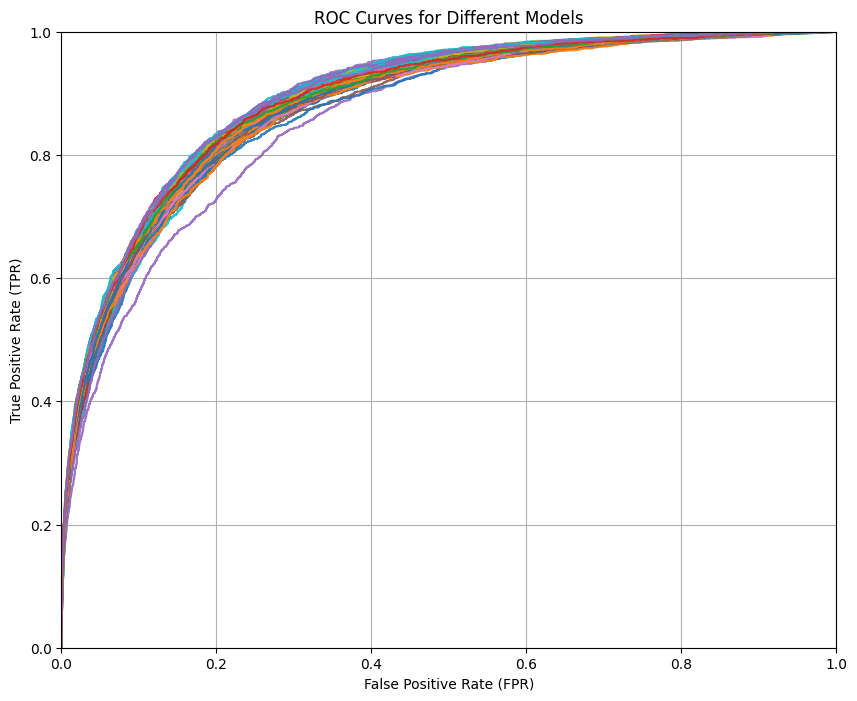

In [85]:
# visualize the result ROC curves of each model in a single plot with different colors per model

# -- plot settings -- #

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("ROC Curves for Different Models")
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.grid(True)

# -- plot the ROC curves -- #

# create groups of rate data for each model - nr groups should match the number of models & axis
ROC_perModel = ROC_df.groupby("Model")

# plot each model's ROC curve
for model_index, group in ROC_perModel:
    # get x,y pairs
    data = group[["FPR", "TPR"]].values

    # plot the ROC curve
    ax.plot(data[:, 0], data[:, 1], alpha=.9 ,label=f"Model {model_index + 1} (AUC: {scores[model_index]['roc_auc']:.2%})")

# set legend labels corerctly
    
